In [82]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import glob
import os
from tensorflow.keras.callbacks import TensorBoard
import time
import pickle
import matplotlib.pyplot as plt
from sklearn import metrics

# set parameters

In [83]:
batch_size = 32
epoch = 150
img_height = 300
img_width = 300
root = '/A_LUAD/project/final_project'
name = '2-class-original{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='/A_LUAD/project/final_project/logs/{}'.format(name))

# load data

In [84]:
train_dir = '/A_LUAD/project/final_project/data/temp/two_train'
val_dir = '/A_LUAD/project/final_project/data/temp/two_val'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  val_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

Found 3075 files belonging to 2 classes.
Found 652 files belonging to 2 classes.


# build model

In [85]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(name='confusion_matrix_metric',**kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        
    def reset_state(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    
    def fill_output(self,output):
        results=self.result()
        for i in range(self.num_classes):
            output['precision_{}'.format(i)]=results[0][i]
            output['recall_{}'.format(i)]=results[1][i]
            output['F1_{}'.format(i)]=results[2][i]
    # def get_config(self):
    #     config = super(ConfusionMatrixMetric, self).get_config()
    #     config.update({"num_classes": self.num_classes,"total_cm": self.total_cm})
    #     return config
    
class MySequential(keras.Sequential):
    
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.

        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                regularization_losses=self.losses,
            )

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        output={m.name: m.result() for m in self.metrics[:-1]}
        if 'confusion_matrix_metric' in self.metrics_names:
            self.metrics[-1].fill_output(output)
        return output
        
        
    def test_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.

        x, y = data

        y_pred = self(x, training=False)  # Forward pass
        # Compute the loss value.
        # The loss function is configured in `compile()`.
        loss = self.compiled_loss(
            y,
            y_pred,
            regularization_losses=self.losses,
        )

        self.compiled_metrics.update_state(y, y_pred)
        output={m.name: m.result() for m in self.metrics[:-1]}
        if 'confusion_matrix_metric' in self.metrics_names:
            self.metrics[-1].fill_output(output)    
        return output

## with data augmentatiom

In [86]:
data_augmentation = keras.Sequential(
  [
    keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

####### model
num_classes = 2
# Dropout
model = MySequential([
  data_augmentation,
  keras.layers.experimental.preprocessing.Rescaling(1./300),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.2),
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(num_classes)
])
loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer=keras.optimizers.Adam()
model.compile(loss=loss,optimizer=optimizer,metrics=['accuracy',ConfusionMatrixMetric(2)])

# train

In [87]:
# es=keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=100)
history=model.fit(train_ds,validation_data=val_ds,epochs=epoch, verbose=1, callbacks=[tensorboard])

Epoch 1/150
97/97 [==============================] - 13s 97ms/step - loss: 0.6622 - accuracy: 0.6143 - precision_0: 0.6061 - recall_0: 0.9449 - F1_0: 0.7371 - precision_1: 0.3438 - recall_1: 0.0490 - F1_1: 0.0639 - val_loss: 0.5466 - val_accuracy: 0.8466 - val_precision_0: 0.8466 - val_recall_0: 1.0000 - val_F1_0: 0.9169 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_F1_1: 0.0000e+00
Epoch 2/150
97/97 [==============================] - 9s 89ms/step - loss: 0.6412 - accuracy: 0.6485 - precision_0: 0.6281 - recall_0: 0.9936 - F1_0: 0.7695 - precision_1: 0.7946 - recall_1: 0.0523 - F1_1: 0.0949 - val_loss: 0.6025 - val_accuracy: 0.8083 - val_precision_0: 0.8726 - val_recall_0: 0.9058 - val_F1_0: 0.8889 - val_precision_1: 0.3418 - val_recall_1: 0.2700 - val_F1_1: 0.3017
Epoch 3/150
97/97 [==============================] - 9s 89ms/step - loss: 0.6138 - accuracy: 0.6722 - precision_0: 0.6516 - recall_0: 0.9657 - F1_0: 0.7781 - precision_1: 0.7632 - recall_1: 0.1779 - F1_1: 0.

# results

## loading test data

In [88]:
import glob
group1 = glob.glob('/A_LUAD/project/final_project/data/temp/two_test/group1/*.png')
group2 = glob.glob('/A_LUAD/project/final_project/data/temp/two_test/group2/*.png')

data = []
labels = []
filenames = []
for i in group1:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (300,300))
    image=np.array(image)
    data.append(image)
    labels.append(0)
    filenames.append(i)
for i in group2:   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (300,300))
    image=np.array(image)
    data.append(image)
    labels.append(1)
    filenames.append(i)

x_test = np.array(data)
y_test = np.array(labels)

## save eva results

In [89]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

In [90]:
name

'2-class-original1674758924'

In [91]:
######### evaluate model
testname = name + '_test'
results = model.evaluate(x_test, y_test)

32/32 [==============================] - 2s 35ms/step - loss: 2.1562 - accuracy: 0.6196 - precision_0: 0.8044 - recall_0: 0.5258 - F1_0: 0.6274 - precision_1: 0.2223 - recall_1: 0.2980 - F1_1: 0.2501


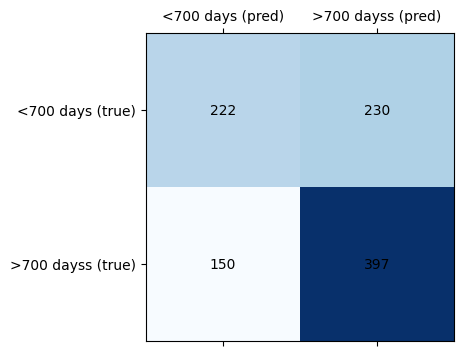

In [92]:
test_path = '/A_LUAD/project/final_project/test_results'
## not sure
# test_name = name + '_pred.pickle'
# with open(os.path.join(test_path,test_name), 'wb') as file_pi:
#     pickle.dump(y_pred_lbls, file_pi)

######### visualization
y_pred=model.predict(x_test)
y_pred_lbls=np.argmax(y_pred,-1)

lbls=dict(map(lambda x: x.split('\t'),"""0 	<700 days
1 	>700 dayss""".split('\n')))
lbls={int(k):v for k,v in lbls.items()}

cm=ConfusionMatrixMetric(num_classes)
_=cm.update_state(y_test,y_pred)
fig, ax = plt.subplots(figsize=(6,4))
cm_matrix = cm.total_cm.numpy().astype(np.int32)
ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(num_classes):
    for j in range(num_classes):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
plt.xticks(range(num_classes),['{} ({})'.format(lbls[i],'pred') for i in range(num_classes)])
plt.yticks(range(num_classes),['{} ({})'.format(lbls[i],'true') for i in range(num_classes)])
plt_name = name + '_loss'+str(round(results[0],2)) + '_acc'+str(round(results[1],2))+ '_p1_'+str(round(results[2],2))+ '_r1_'+str(round(results[3],2))+ '_f11_'+str(round(results[4],2))+ '_p2_'+str(round(results[5],2))+ '_r2_'+str(round(results[6],2))+ '_f12_'+str(round(results[7],2))+'_test.png'
plt.savefig(os.path.join(test_path, plt_name))
# plt.show()

In [93]:
auc = metrics.roc_auc_score(y_test, y_pred_lbls)
print(auc)

0.6084637038714792


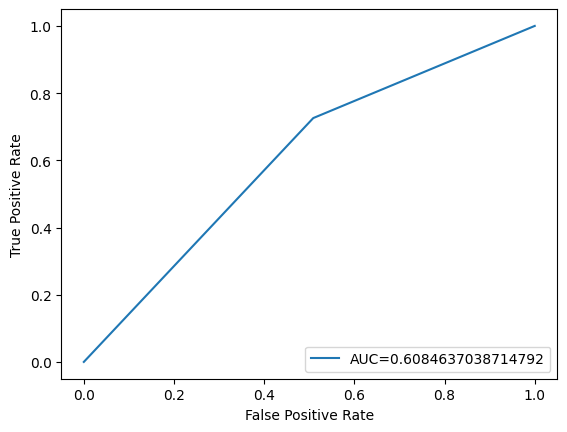

In [94]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_lbls)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt_name = name + '_Roc_'+ str(round(auc,2))+'_test.png'
plt.savefig(os.path.join(test_path, plt_name))
plt.show()

# case prediction

In [95]:
casepredict = dict()
for index, filename in enumerate(filenames):
  caseid = filename.split('\\')[-1].split('_')[0]
  # print(caseid)
  if caseid in casepredict:
    casepredict[caseid].append(y_pred_lbls[index])
    # print(casepredict)
  else:
    # print(caseid)
    casepredict[caseid] = [y_pred_lbls[index]]
# print(casepredict)
# len(casepredict)

In [96]:
case_pred_dict = dict()
for caseid in casepredict:
  counts = np.bincount(casepredict[caseid])
  #返回众数
  case_pred = np.argmax(counts)
  # print(case_pred)
  # case_pred_dict.append(caseid)
  case_pred_dict[caseid] = case_pred
# print(case_pred_dict)  
caseid_list = list(case_pred_dict.keys())

In [97]:
case_true_list = []
testdata = pd.read_csv('/A_LUAD/project/final_project/data/temp/two_test_cases.csv')
for caseid in caseid_list:
  case_truedf = testdata[testdata['case_submitter_id']==caseid]
  case_true = case_truedf['group'].values[0]-1
  case_true_list.append(case_true)
# print(case_true_list)

[[10 12]
 [ 8 11]]


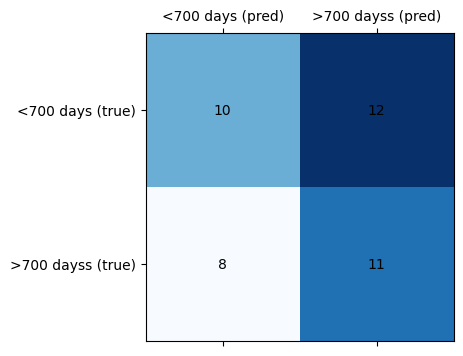

In [98]:
from sklearn.metrics import confusion_matrix
case_pred_list = list(case_pred_dict.values())
case_matrix = confusion_matrix(case_true_list, case_pred_list)
print(case_matrix)

lbls=dict(map(lambda x: x.split('\t'),"""0 	<700 days
1 	>700 dayss""".split('\n')))
lbls={int(k):v for k,v in lbls.items()}


fig, ax = plt.subplots(figsize=(6,4))
cm_matrix = case_matrix
ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(num_classes):
    for j in range(num_classes):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center')
plt.xticks(range(num_classes),['{} ({})'.format(lbls[i],'pred') for i in range(num_classes)])
plt.yticks(range(num_classes),['{} ({})'.format(lbls[i],'true') for i in range(num_classes)])
plt_name = name + '_case_loss'+str(round(results[0],2)) + '_acc'+str(round(results[1],2))+'_test.png'
plt.savefig(os.path.join(test_path, plt_name))
# plt.show()

In [99]:
for index, case_pred in enumerate(case_pred_list):
  if case_pred != case_true_list[index]:
    print(caseid_list[index],case_true_list[index]+1)

TCGA-44-7659 1
TCGA-44-A4SU 1
TCGA-49-4490 1
TCGA-49-4505 1
TCGA-49-6745 1
TCGA-50-5931 1
TCGA-50-7109 1
TCGA-55-8087 1
TCGA-93-8067 1
TCGA-95-7562 1
TCGA-95-7944 1
TCGA-95-A4VP 1
TCGA-05-4245 2
TCGA-05-4249 2
TCGA-44-3918 2
TCGA-44-7667 2
TCGA-55-7724 2
TCGA-55-8089 2
TCGA-93-A4JN 2
TCGA-97-7553 2


## survival analysis for true value

In [100]:
clinical_data = pd.read_csv('/A_LUAD/project/final_project/data/temp/two_test_cases.csv')

In [101]:
clinical_data['died'] = np.where(clinical_data['vital_status'] == 'Dead', 1, 0)

In [102]:
clinical_data['os'] = clinical_data['survival_days']

In [103]:
clinical_data

,case_submitter_id,vital_status,survival_days,survival_year,group,ajcc_pathologic_stage,ajcc_staging_system_edition,ajcc_pathologic_t,ajcc_pathologic_m,ajcc_pathologic_n,primary_diagnosis,died,os
0,TCGA-97-A4M3,Alive,540,1,1,Stage IA,7th,T1b,M0,N0,Adenocarcinoma with mixed subtypes,0,540
1,TCGA-50-7109,Dead,308,1,1,Stage IA,7th,T1,M0,N0,"Adenocarcinoma, NOS",1,308
2,TCGA-49-6745,Alive,522,1,1,Stage IIIA,7th,T2a,M0,N2,"Papillary adenocarcinoma, NOS",0,522
3,TCGA-44-7667,Alive,1097,3,2,Stage IIB,6th,T3,MX,N0,"Adenocarcinoma, NOS",0,1097
4,TCGA-95-7944,Alive,377,1,1,Stage IA,7th,T1a,M0,N0,"Adenocarcinoma, NOS",0,377
5,TCGA-86-7711,Dead,1046,3,2,Stage IIA,7th,T2a,M0,N1,"Adenocarcinoma, NOS",1,1046
6,TCGA-97-A4M0,Alive,652,2,1,Stage IB,7th,T2a,M0,N0,Adenocarcinoma with mixed subtypes,0,652
7,TCGA-55-7570,Alive,824,2,2,Stage IA,7th,T1a,MX,N0,"Adenocarcinoma, NOS",0,824
8,TCGA-L9-A443,Dead,193,1,1,Stage IA,7th,T1a,MX,N0,"Adenocarcinoma, NOS",1,193
9,TCGA-55-7724,Alive,705,2,2,Stage IB,7th,T2a,MX,N0,"Adenocarcinoma, NOS",0,705


In [104]:
file_case_list = clinical_data['case_submitter_id'].tolist()

In [105]:
predicted_case = []
for i in file_case_list:
  predicted_case.append(case_pred_dict[i])

In [106]:
clinical_data['predicted_case'] = predicted_case

In [107]:
clinical_data

,case_submitter_id,vital_status,survival_days,survival_year,group,ajcc_pathologic_stage,ajcc_staging_system_edition,ajcc_pathologic_t,ajcc_pathologic_m,ajcc_pathologic_n,primary_diagnosis,died,os,predicted_case
0,TCGA-97-A4M3,Alive,540,1,1,Stage IA,7th,T1b,M0,N0,Adenocarcinoma with mixed subtypes,0,540,0
1,TCGA-50-7109,Dead,308,1,1,Stage IA,7th,T1,M0,N0,"Adenocarcinoma, NOS",1,308,1
2,TCGA-49-6745,Alive,522,1,1,Stage IIIA,7th,T2a,M0,N2,"Papillary adenocarcinoma, NOS",0,522,1
3,TCGA-44-7667,Alive,1097,3,2,Stage IIB,6th,T3,MX,N0,"Adenocarcinoma, NOS",0,1097,0
4,TCGA-95-7944,Alive,377,1,1,Stage IA,7th,T1a,M0,N0,"Adenocarcinoma, NOS",0,377,1
5,TCGA-86-7711,Dead,1046,3,2,Stage IIA,7th,T2a,M0,N1,"Adenocarcinoma, NOS",1,1046,1
6,TCGA-97-A4M0,Alive,652,2,1,Stage IB,7th,T2a,M0,N0,Adenocarcinoma with mixed subtypes,0,652,0
7,TCGA-55-7570,Alive,824,2,2,Stage IA,7th,T1a,MX,N0,"Adenocarcinoma, NOS",0,824,1
8,TCGA-L9-A443,Dead,193,1,1,Stage IA,7th,T1a,MX,N0,"Adenocarcinoma, NOS",1,193,0
9,TCGA-55-7724,Alive,705,2,2,Stage IB,7th,T2a,MX,N0,"Adenocarcinoma, NOS",0,705,0


In [108]:
save_path = 'two_class_survival' + name+ '.csv'
clinical_data.to_csv(os.path.join('/A_LUAD/project/final_project/test_results', save_path),index=False)